In [1]:
import sys, os, distutils.core

In [2]:
# !git clone 'https://github.com/facebookresearch/detectron2'

In [3]:
# dist = distutils.core.run_setup("./detectron2/setup.py")
# !python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}

In [4]:
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt

sys.path.insert(0, os.path.abspath('./detectron2'))
import torch, detectron2

import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.engine import DefaultTrainer
from detectron2.engine import launch
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode
from detectron2.utils.visualizer import Visualizer, ColorMode


In [5]:
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243
torch:  2.1 ; cuda:  2.1.0
detectron2: 0.6


## Fine Tuning on Custom Dataset

### Custom Dataset

In [6]:
# # download, decompress the data
# !wget https://github.com/matterport/Mask_RCNN/releases/download/v2.1/balloon_dataset.zip
# !unzip balloon_dataset.zip > /dev/null

In [7]:
# custom dataset directory folder name
custom_dataset_dir = "balloon"

# new classes
new_thing_classes = ["balloon"]
new_stuff_classes = []

# number of new classes
num_new_classes = len(new_thing_classes) + len(new_stuff_classes)

In [8]:
def generate_segmentation_file(img_dir):
    json_file = os.path.join(img_dir, "via_region_data.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)

    for idx, v in enumerate(imgs_anns.values()):
        filename = os.path.join(img_dir, v["filename"])
        height, width = cv2.imread(filename).shape[:2]

        # Because we only have one object category (balloon) to train,
        # 1 is the category of the background
        segmentation = np.ones((height, width), dtype=np.uint8)

        annos = v["regions"]
        for _, anno in annos.items():
            assert not anno["region_attributes"]
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = np.array(poly, np.int32)

            category_id = 0  # change to 255 for better visualisation
            cv2.fillPoly(segmentation, [poly], category_id)
            output = os.path.join(img_dir, "segmentation", v["filename"])
            cv2.imwrite(output, segmentation)

In [9]:
# if your dataset is in COCO format, this cell can be replaced by the following three lines:
# from detectron2.data.datasets import register_coco_instances
# register_coco_instances("my_dataset_train", {}, "json_annotation_train.json", "path/to/image/dir")
# register_coco_instances("my_dataset_val", {}, "json_annotation_val.json", "path/to/image/dir")

def get_data_dicts(img_dir):
    json_file = os.path.join(img_dir, "via_region_data.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)

    dataset_dicts = []
    for idx, v in enumerate(imgs_anns.values()):
        record = {}

        filename = os.path.join(img_dir, v["filename"])
        height, width = cv2.imread(filename).shape[:2]

        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
        # Pixel-wise segmentation
        record["sem_seg_file_name"] = os.path.join(img_dir, "segmentation", v["filename"])

        annos = v["regions"]
        objs = []
        for _, anno in annos.items():
            assert not anno["region_attributes"]
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": 0,
                # "Things" are well-defined countable objects,
                # while "stuff" is amorphous something with a different label than the background.
                "isthing": True,
                "iscrowd": 0
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

In [10]:
# Generate the custom dataset
for d in ["train", "val"]:
    os.makedirs(os.path.join(custom_dataset_dir, d, "segmentation"), exist_ok=True)
    generate_segmentation_file(os.path.join(custom_dataset_dir, d))

In [11]:
# Register custom dataset
for d in ["train", "val"]:
    DatasetCatalog.register(custom_dataset_dir + "_" + d, lambda d=d: get_data_dicts(custom_dataset_dir + "/" + d))
    # For semantic / panoptic segmentation, add a stuff class.
    MetadataCatalog.get(custom_dataset_dir + "_" + d).set(thing_classes=new_thing_classes, stuff_classes=new_stuff_classes)
metadata = MetadataCatalog.get(custom_dataset_dir + "_train")

In [12]:
def visualise_dataset(d: str = "train"):
    dataset_dicts = get_data_dicts(os.path.join(custom_dataset_dir, d))
    for d in random.sample(dataset_dicts, 3):
        img = cv2.imread(d["file_name"])
        visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=0.5)
        vis = visualizer.draw_dataset_dict(d)
        plt.imshow(vis.get_image())
        plt.show()

### Fine Tuning

In [13]:
def train(cfg):
    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
    trainer = DefaultTrainer(cfg)
    trainer.resume_or_load(resume=False)
    trainer.train()

In [14]:
def init_cfg(config_file: str):
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file(config_file))
    # cfg.DATASETS.TRAIN = ("balloon_train",)
    cfg.DATASETS.TRAIN = (custom_dataset_dir + "_train",)
    cfg.DATASETS.TEST = ()
    cfg.DATALOADER.NUM_WORKERS = 2
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(config_file)  # Let training initialize from model zoo

    # Freeze the weights
    """
    Freeze the first several stages of the ResNet. Commonly used in
    fine-tuning.
    Layers that produce the same feature map spatial size are defined as one
    "stage" by :paper:`FPN`.
    Args:
        freeze_at (int): number of stages to freeze.
            `0` means not freezing any parameters.
            `1` means freezing the stem layer. 
            `2` means freezing the stem layer and one residual block, etc.
    """
    cfg.MODEL.BACKBONE.FREEZE_AT = 5 # 0 ~ 5
    cfg.MODEL.ROI_HEADS.FREEZE_AT = 0
    cfg.MODEL.PROPOSAL_GENERATOR.FREEZE_AT = 0

    cfg.SOLVER.IMS_PER_BATCH = 1
    cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
    cfg.SOLVER.MAX_ITER = 100  # 100 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128  # faster, and good enough for this toy dataset (default: 512)
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = num_new_classes # number of classes

    return cfg

In [15]:
# This cell shows how to retrieve the model
from detectron2.engine.defaults import build_model
cfg = init_cfg("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml")
model = build_model(cfg)
print(model)

PanopticFPN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2): Sequential(
        (0): BottleneckBlock(
  

In [16]:
# print layers with requires_grad = True
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

backbone.fpn_lateral2.weight
backbone.fpn_lateral2.bias
backbone.fpn_output2.weight
backbone.fpn_output2.bias
backbone.fpn_lateral3.weight
backbone.fpn_lateral3.bias
backbone.fpn_output3.weight
backbone.fpn_output3.bias
backbone.fpn_lateral4.weight
backbone.fpn_lateral4.bias
backbone.fpn_output4.weight
backbone.fpn_output4.bias
backbone.fpn_lateral5.weight
backbone.fpn_lateral5.bias
backbone.fpn_output5.weight
backbone.fpn_output5.bias
proposal_generator.rpn_head.conv.weight
proposal_generator.rpn_head.conv.bias
proposal_generator.rpn_head.objectness_logits.weight
proposal_generator.rpn_head.objectness_logits.bias
proposal_generator.rpn_head.anchor_deltas.weight
proposal_generator.rpn_head.anchor_deltas.bias
roi_heads.box_head.fc1.weight
roi_heads.box_head.fc1.bias
roi_heads.box_head.fc2.weight
roi_heads.box_head.fc2.bias
roi_heads.box_predictor.cls_score.weight
roi_heads.box_predictor.cls_score.bias
roi_heads.box_predictor.bbox_pred.weight
roi_heads.box_predictor.bbox_pred.bias
roi_he

In [17]:
# number of trainable parameters
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

22093900


In [18]:
# Train
launch(
    train,
    1,  # Number of GPUs per machine
    num_machines=1,
    machine_rank=0,
    dist_url=None,
    args=(cfg,),
    )   

[11/25 01:38:54 d2.engine.defaults]: Model:
PanopticFPN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2): 

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in

[11/25 01:38:55 d2.engine.train_loop]: Starting training from iteration 0


/home/sam/anaconda3/envs/detectron2/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392036766/work/aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[11/25 01:39:09 d2.utils.events]:  eta: 0:00:50  iter: 19  total_loss: 6.102  loss_sem_seg: 4.288  loss_rpn_cls: 0.02261  loss_rpn_loc: 0.006409  loss_cls: 0.7595  loss_box_reg: 0.6597  loss_mask: 0.6756    time: 0.6208  last_time: 0.5052  data_time: 0.0112  last_data_time: 0.0041   lr: 4.7703e-05  max_mem: 1785M
[11/25 01:39:22 d2.utils.events]:  eta: 0:00:36  iter: 39  total_loss: 5.093  loss_sem_seg: 3.713  loss_rpn_cls: 0.01748  loss_rpn_loc: 0.003662  loss_cls: 0.4795  loss_box_reg: 0.466  loss_mask: 0.4886    time: 0.6061  last_time: 0.6484  data_time: 0.0043  last_data_time: 0.0058   lr: 9.7653e-05  max_mem: 1785M
[11/25 01:39:34 d2.utils.events]:  eta: 0:00:24  iter: 59  total_loss: 2.684  loss_sem_seg: 1.155  loss_rpn_cls: 0.0194  loss_rpn_loc: 0.005585  loss_cls: 0.3206  loss_box_reg: 0.6913  loss_mask: 0.2961    time: 0.6060  last_time: 0.4884  data_time: 0.0048  last_data_time: 0.0057   lr: 0.0001476  max_mem: 1785M
[11/25 01:39:47 d2.utils.events]:  eta: 0:00:12  iter: 79 

In [19]:
def visualise_prediction(predictor, d: str = "val"):
    dataset_dicts = get_data_dicts(os.path.join("balloon", d))
    for d in random.sample(dataset_dicts, 3):
        im = cv2.imread(d["file_name"])
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        outputs = predictor(im)
        v = Visualizer(im,
                       metadata=metadata,
                       scale=0.8,
                    #    instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
        )
        v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
        plt.imshow(v.get_image())
        plt.show()

def get_predictor(cfg, model_name: str):
    cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, model_name)
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set the testing threshold for this model
    cfg.DATASETS.TEST = ("balloon_val",)
    predictor = DefaultPredictor(cfg)
    return predictor

[11/25 01:40:02 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


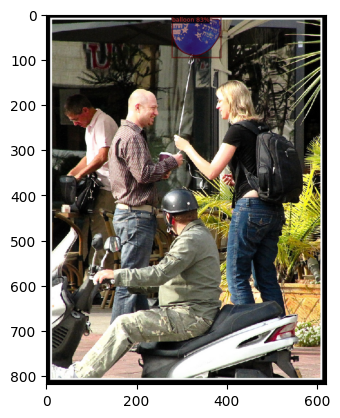

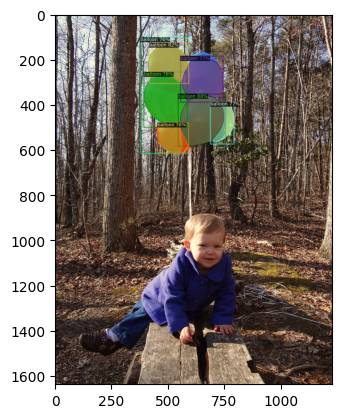

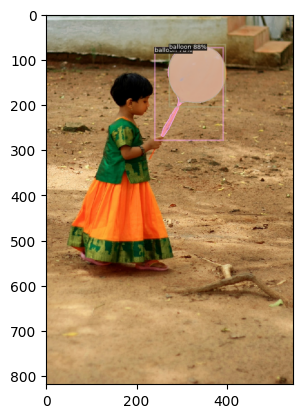

In [20]:
# Check result
predictor = get_predictor(cfg, "model_final.pth")
visualise_prediction(predictor, "val")